# BERT and Fine-Tuning

In this section, we utilize the BERT (Bidirectional Encoder Representations from Transformers) model to perform NLP tasks. The objective is to establish a pre-trained BERT model, prepare data, fine-tune the model, and evaluate its performance using various metrics.

### Model Used
- **Model**: BERT (bert-base-uncased)
- **Framework**: PyTorch
- **Library**: Hugging Face Transformers

### Dataset
- **Source**: [Amazon Product Review Dataset](https://nijianmo.github.io/amazon/index.html)
- **Description**: A comprehensive dataset of product reviews and ratings from Amazon, providing rich text data for training and evaluating the BERT model.

## Objectives
1. Establish the pre-trained `bert-base-uncased` model.
2. Prepare and preprocess the dataset for BERT.
3. Fine-tune and train the BERT model with the dataset.
4. Evaluate the model using various metrics.
5. Provide a general conclusion on the use of the pre-trained BERT model.


## Data Preparation
- **Sampling Dataset**: The Amazon Product Review Dataset is sampled to reduce computation complexity.
- **Cleaning Text Data**: Text data undergoes cleaning steps including removing duplicates, special characters, numbers, stopwords, and stemming.
- **Visualization**: Distribution of review scores is visualized to understand the class distribution.


In [2]:
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

pd.options.display.max_rows = None
seed=40

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
rn.seed(a=40)
p = 0.1
review = pd.read_csv('../input/amazon-product-reviews/Reviews.csv',skiprows=lambda i: i>0 and rn.random() > p)
review.shape

(56733, 10)

In [4]:
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
1,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
2,26,B001GVISJM,A3FONPR03H3PJS,"Deborah S. Linzer ""Cat Lady""",0,0,5,1288310400,Twizzlers - Strawberry,Product received is as advertised.<br /><br />...
3,41,B001EO5QW8,AQCY5KRO7489S,Garrett,0,0,5,1303430400,Why wouldn't you buy oatmeal from Mcanns? Tast...,The variety packs taste great!<br /><br />I ha...
4,45,B001EO5QW8,A2G7B7FKP2O2PU,D. Leschke,0,0,5,1209686400,Great taste and convenience,We really like the McCann's steel cut oats but...


In [5]:
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0

In [6]:
review['review_score']= review.Score.apply(score_round)

In [7]:
review = review.rename(columns={'Text':'review_text'})

In [9]:
rn.seed(a=40)
q = 0.8 
review_val = pd.read_csv('Reviews.csv',skiprows=lambda i: i>0 and rn.random() > q)
review_val.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
4,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...


In [10]:
review_val['review_score']=review_val.Score.apply(score_round)

In [11]:
review_val = review_val.rename(columns={'Text':'review_text'})

In [12]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56733 entries, 0 to 56732
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      56733 non-null  int64 
 1   ProductId               56733 non-null  object
 2   UserId                  56733 non-null  object
 3   ProfileName             56731 non-null  object
 4   HelpfulnessNumerator    56733 non-null  int64 
 5   HelpfulnessDenominator  56733 non-null  int64 
 6   Score                   56733 non-null  int64 
 7   Time                    56733 non-null  int64 
 8   Summary                 56729 non-null  object
 9   review_text             56733 non-null  object
 10  review_score            56733 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 4.8+ MB


In [13]:
review.review_text = review.review_text.astype('str')
review_val.review_text = review.review_text.astype('str')

review.Summary = review.Summary.astype('str')
review_val.Summary = review.Summary.astype('str')

In [14]:
temp = review.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')


,review_score,review_text
1,1,48531
0,0,8202


<AxesSubplot:xlabel='review_score', ylabel='count'>

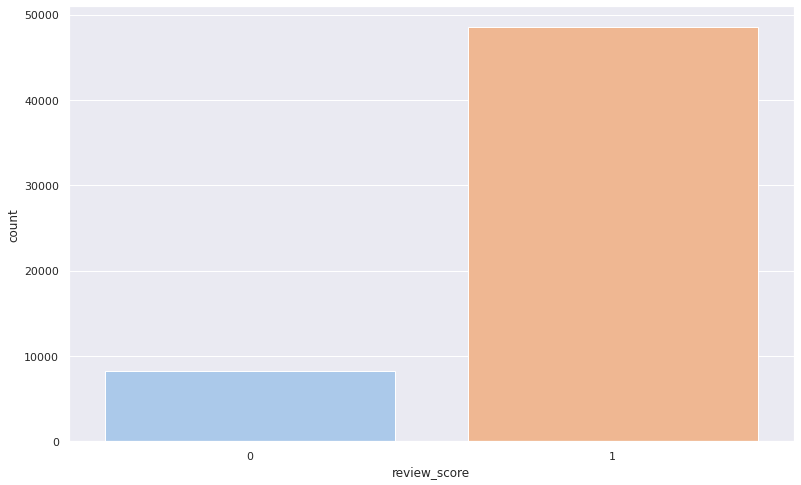

In [15]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

In [22]:
review_vis = review.copy()

In [23]:
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

<AxesSubplot:xlabel='Num_word_review', ylabel='Count'>

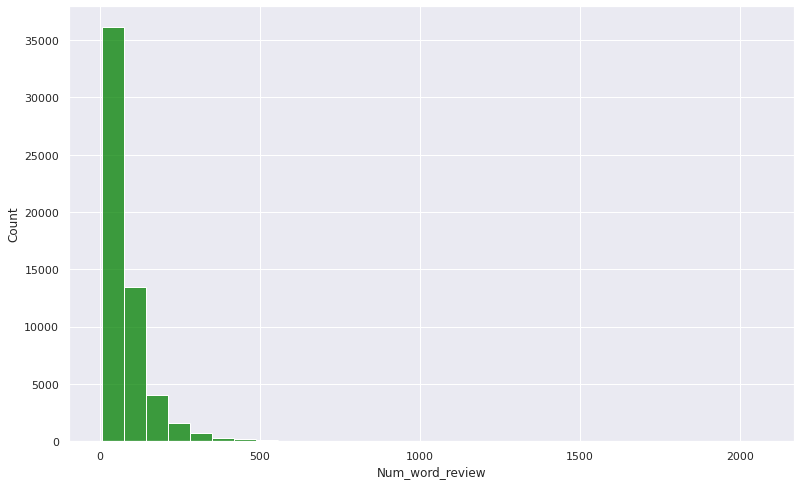

In [24]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green')

In [25]:
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,162221
1,I,138371
2,and,122481
3,a,115814
4,to,98518
5,of,78365
6,is,71102
7,it,62483
8,for,52010
9,in,50791


In [26]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

In [28]:
review = review.drop_duplicates(keep='first')

In [29]:
review.shape

(56733, 11)

In [30]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [31]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [32]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [33]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [34]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [35]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [36]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

In [37]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [38]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)

In [39]:
cleaning(review,'review_text')

In [40]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

In [41]:
review[['review_text']].head(20)

,review_text
0,confection around centuries light pillowy citr...
1,know cactus tequila unique combination ingredi...
2,product received advertised br br link
3,variety packs taste great br br every morning ...
4,really like mccann steel cut oats find cook of...
5,stuff buy big box stores nothing healthy carbs...
6,great product nice combination chocolates perf...
7,halloween sent bag daughters class share choco...
8,purchased mango flavor take like mango hint sw...
9,peppermint stick delicious fun eat dad got one...


In [42]:
review_vis2 = review.copy()

In [43]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,br,63179
1,like,25623
2,good,20004
3,taste,17342
4,one,17231
5,great,16743
6,coffee,16248
7,product,15012
8,flavor,14743
9,tea,13534


<AxesSubplot:xlabel='count', ylabel='Common_words'>

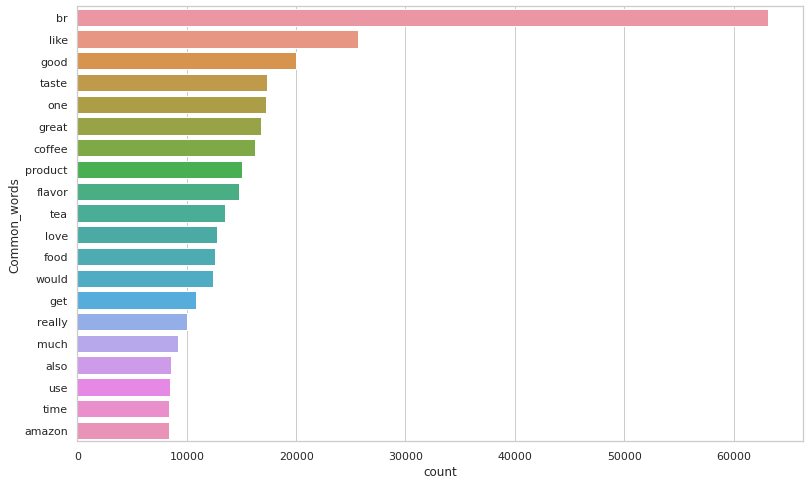

In [44]:
sns.set_theme(style = "whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

## Model Preparation
- **Dataset Split**: The dataset is split into training, validation, and holdout sets.
- **Tokenization**: BERT tokenizer is used to tokenize the text data for input into the model.
- **Dataset Creation**: TensorFlow datasets are created from the tokenized inputs for training, validation, and holdout.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import logging
transformers.logging.set_verbosity_error()


In [46]:
reviews = review["review_text"].values.tolist()
labels = review["review_score"].tolist()

In [47]:
training_sentences, test_sentences, training_labels, test_labels = train_test_split(reviews, labels, test_size=.4)
validation_sentences, holdout_sentences, validation_labels, holdout_labels = train_test_split(test_sentences, test_labels, test_size=.5)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [49]:
tokenizer([training_sentences[0]], truncation=True,padding=True, max_length=512)

{'input_ids': [[101, 1436, 1231, 10550, 1518, 1189, 2623, 1427, 1588, 1276, 1180, 2039, 4417, 5095, 11785, 1176, 4489, 4346, 6529, 21820, 10212, 2633, 6363, 1293, 2956, 1231, 10550, 6243, 5540, 1253, 4417, 1293, 2881, 1231, 10550, 1413, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [50]:
train_encodings = tokenizer(training_sentences,truncation=True,padding=True)

validation_encodings = tokenizer(validation_sentences,truncation=True,padding=True)

holdout_encodings = tokenizer(holdout_sentences,truncation=True,padding=True)

In [51]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),training_labels));

validation_dataset = tf.data.Dataset.from_tensor_slices((dict(validation_encodings),validation_labels));

holdout_dataset = tf.data.Dataset.from_tensor_slices((dict(holdout_encodings),holdout_labels));

2022-04-26 06:14:51.176493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 06:14:51.177781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 06:14:51.178439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 06:14:51.180330: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Fine-Tuning BERT Model
- **Model Loading**: The pre-trained BERT model (`bert-base-cased`) is loaded for sequence classification.
- **Model Compilation**: The model is compiled with an Adam optimizer and sparse categorical cross-entropy loss.
- **Model Training**: The model is trained on the training dataset with validation on the validation dataset.


In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased',num_labels=2)

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

In [54]:
history = model.fit(train_dataset.shuffle(100).batch(8),
          epochs=3,
          batch_size=8,
          validation_data=validation_dataset.shuffle(100).batch(8), verbose=1)

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:376: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)
2022-04-26 06:19:01.391045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


4255/4255 [==============================] - 2722s 634ms/step - loss: 0.2595 - accuracy: 0.8954 - val_loss: 0.2181 - val_accuracy: 0.9141
Epoch 2/3
4255/4255 [==============================] - 2692s 633ms/step - loss: 0.1707 - accuracy: 0.9330 - val_loss: 0.2078 - val_accuracy: 0.9122
Epoch 3/3
4255/4255 [==============================] - 2697s 634ms/step - loss: 0.1050 - accuracy: 0.9624 - val_loss: 0.2877 - val_accuracy: 0.9112


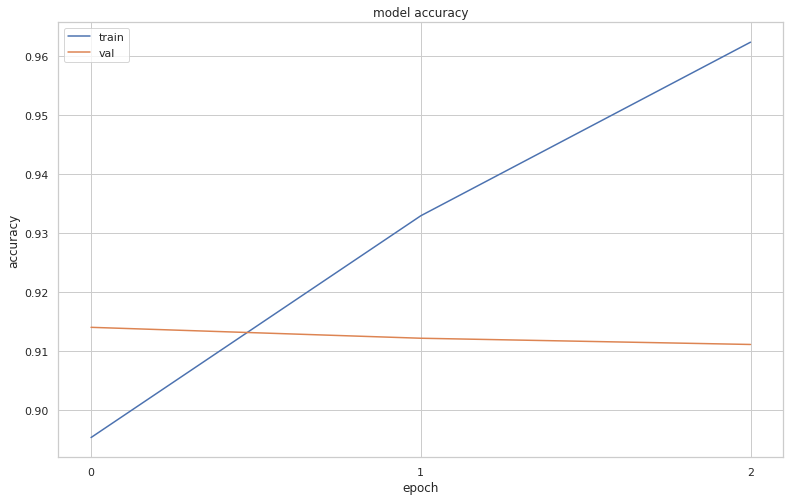

In [55]:
from matplotlib.ticker import MaxNLocator


ax = plt.figure().gca()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [58]:
model.save_pretrained("./part3v0")

In [59]:
loaded_model = TFBertForSequenceClassification.from_pretrained("part3v0")
result = model.evaluate(holdout_dataset.batch(8))
dict(zip(model.metrics_names, result))

1419/1419 [==============================] - 281s 198ms/step - loss: 0.2927 - accuracy: 0.9127


{'loss': 0.2927491366863251, 'accuracy': 0.9126641154289246}

In [60]:
tf_output = loaded_model.predict(holdout_dataset.batch(8))
pred_label = tf.argmax(tf.nn.softmax(tf_output["logits"], axis=1).numpy(), 1).numpy()

## Evaluation
- **Model Performance**: The model's performance is evaluated using accuracy metrics on the holdout dataset.
- **Confusion Matrix**: Confusion matrix is generated to visualize true positive, false positive, true negative, and false negative predictions.
- **Precision, Recall, F1-Score**: Metrics are calculated to assess the model's precision, recall, and F1-score.


In [61]:
cm = tf.math.confusion_matrix(holdout_labels, pred_label, num_classes=2, weights=None, dtype=tf.dtypes.int32,name=None).numpy()

print("confusion matrix\n",cm)

confusion matrix
 [[1200  469]
 [ 522 9156]]


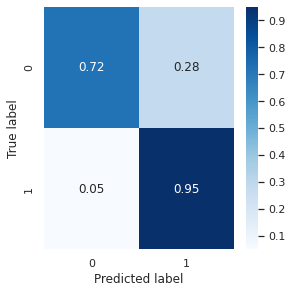

In [68]:
cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

cm_df = pd.DataFrame(cm_norm, index = [0,1], columns =[0,1])

figure = plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [66]:
tp = cm[0][0]
fn = cm[0][1]

tn = cm[1][1]
fp = cm[1][0]

recall = round(tp / (tp+fn), 2)
precision = round(tp / (tp+fp), 2)
f1score = (2*precision*recall) / (precision + recall)

print("recall score:", recall)
print("precision score:", precision)
print("F1-Score:",f1score)

recall score: 0.72
precision score: 0.7
F1-Score: 0.7098591549295775


## Results Evaluation

### Model Performance
- The model achieves an accuracy of approximately 91.27% on the holdout dataset, indicating its ability to correctly classify reviews into positive and negative sentiments.

### Confusion Matrix
- The confusion matrix reveals that out of all actual positive reviews, the model correctly identifies approximately 72% (recall score) as positive. However, there is room for improvement in identifying positive reviews, as approximately 28% are falsely classified as negative.

### Precision, Recall, and F1-Score
- The precision score of approximately 70% indicates that out of all reviews predicted as positive by the model, approximately 70% are actually positive.
- The recall score of approximately 72% indicates that the model correctly identifies approximately 72% of all actual positive reviews.
- The F1-score, which combines precision and recall, is approximately 70.99%, suggesting a balanced performance in classifying positive and negative reviews.

## General Conclusion

The fine-tuning of the pre-trained BERT model on the Amazon Product Review Dataset yields promising results for sentiment analysis tasks. The model demonstrates a high level of accuracy in distinguishing between positive and negative sentiments in product reviews. However, there is a slight imbalance between the model's precision and recall, indicating a potential area for improvement.

Overall, the utilization of the pre-trained BERT model proves effective in sentiment analysis, showcasing its capability to capture nuanced language patterns and make informed predictions. Further optimization and fine-tuning may enhance the model's performance, making it even more valuable for real-world applications in understanding customer sentiments and preferences.

